## Import necessary modules, set up environment

In [1]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper, RGBImgPartialObsWrapper
from stable_baselines3 import PPO
import gymnasium
import cv2

/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
env = gymnasium.make("MiniGrid-LockedRoom-v0")
print(env.observation_space)
env = RGBImgPartialObsWrapper(env)
print(env.observation_space)

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x1738e75b0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))
Dict('direction': Discrete(4), 'image': Box(0, 255, (56, 56, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x1738e75b0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))


## Set up the wrappers for the environment

`MissionEncodingWrapper` adds one for every discrete space in the one-hot encoding of the mission, allowing 0 to be encoded as well.

`ImageFeaturesExtractor` extracts relevant features if the observation is just an image, used with `ImgObsWrapper`

`MinigridFeaturesExtractor` extracts relevant features from the entire observation, used with `MissionEncodingWrapper` and `DictObservationSpaceWrapper`

In [62]:

from gymnasium import ObservationWrapper, RewardWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs
    

class RewardFunctionWrapper(RewardWrapper):
    def __init__(self, env, compute_reward_func):
        super().__init__(env)
        self.curr_compute_reward = None
        self.compute_reward_func = compute_reward_func
    
    def reset(self, *args, **kwargs) -> None:
        ret = self.env.reset(*args, **kwargs)
        self.curr_compute_reward = self.compute_reward_func()
        return ret

    def get_reward(self, obs):
        return self.curr_compute_reward(obs)
    
    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)
        reward = self.curr_compute_reward(obs)
        return obs, reward, terminated, truncated, info



In [4]:
class ImageFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gymnasium.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [5]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

### Train the model and save it. -- also try `FlatObsWrapper`

Dict('direction': Discrete(4), 'image': Box(0, 255, (152, 152, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x1738e75b0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))


/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you

(608, 608, 3)


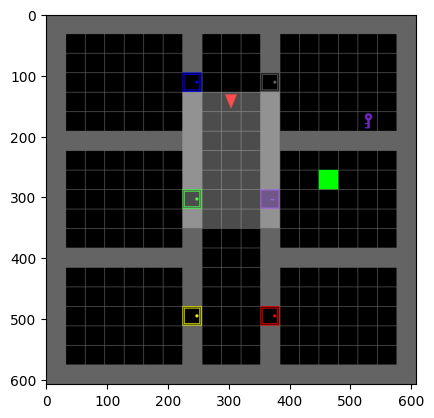

In [6]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
# env = DictObservationSpaceWrapper(env)
# env = MissionEncodingWrapper(env)
env = RGBImgObsWrapper(env)

print(env.observation_space)
env.reset()
r = env.render()
print(r.shape)
plt.imshow(r)

In [7]:
class Actions:
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    PICKUP = 3
    DROP = 4
    TOGGLE = 5
    DONE = 6

DIRECTION:
Up: 3
Left: 2
Down: 1
Right: 0

### Record Video of the trained policy

## How to render image

-- good for passing into GPT4 VLM

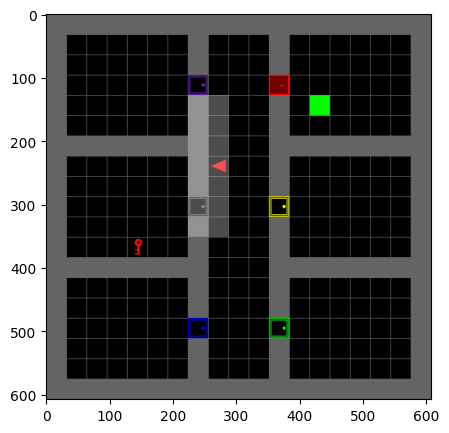

In [8]:
env.reset()
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

## Custom Reward Function

In [9]:
from openai import OpenAI
from api.settings import Settings

openai_client = OpenAI(api_key=Settings().openai_key)

def vision(prompt_text: str, img_base64: str):
    """Run a GPT-4 vision model on the prompt text and image.

    ```
    from PIL import Image
    im = Image.fromarray(r)
    vision("what do you see?", image_to_base64(im))
    ```
    """
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img_base64}",
                        "detail": "low"
                    },
                },
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=600,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=300,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=800,
    )
    return response



## Custom Reward

In [10]:
# custom_parking_env.py
from typing import Callable, List

from gymnasium.envs.registration import register
from minigrid.envs.lockedroom import LockedRoomEnv

from gymnasium import spaces

import numpy as np


class CustomMinigridEnv(LockedRoomEnv):
    def __init__(
        self,
        *args,
        compute_reward: Callable[["CustomMinigridEnv", spaces.Dict], float],
        **kwargs
    ):  
        self.compute_reward_func = compute_reward
        super().__init__(*args, **kwargs)
        
    # this function is useless
    
    # def _reward(self) -> float:
    #     return self.compute_reward_func(current_state)
    
    def get_reward(self, obs):
        return self.compute_reward_func(obs)
    
    def step(self, action):
        obs, _, terminated, truncated, info = super().step(action)
        print("obs inside:", obs)
        reward = self.compute_reward_func(obs)
        return obs, reward, terminated, truncated, info

register( id="CustomLockedRoom-v0", entry_point=CustomMinigridEnv)

In [11]:
image_env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array") # filler env to get the render with filler reward
# purposely have alias so that I can change it later
ob, info = image_env.reset()
render = image_env.render()
ob['mission']

'get the grey key from the yellow room, unlock the grey door and go to the goal'

'get the purple key from the blue room, unlock the purple door and go to the goal'

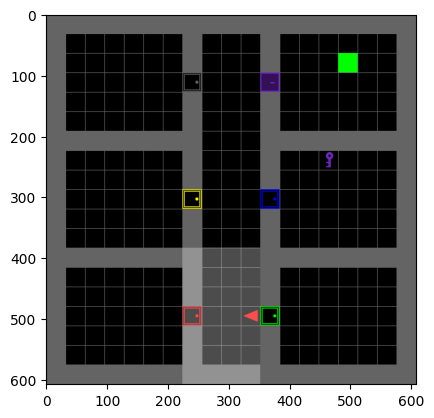

In [12]:
ob, info = image_env.reset()
render = image_env.render()
plt.imshow(render)
ob['mission']

In [13]:
class WithoutMissionExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)


    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return { 'image': observations['image'], 'direction': observations['direction'] }

In [48]:
prompt1 = '''You are an assistant aiding with subgoal generataion for reinforcement learning problems. Specifically, you will
be given an example environment picture and a textual goal description, and you are to output language subgoals that the agent
should achieve in order to efficiently and successfully achieve the main goal.

The goal description is:

“get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

where you can use {lockedroom_color}, {keyroom_color}, and {door_color} as variables in the subgoals and the goal is a light green square.
The variables can be the values “red”, “green”, “blue”, “purple”, “yellow” or “grey”.

These subgoals should be with respect to the image itself:
they should specify specific observations that show that the agent is on track. Output a list of ONLY these text subgoals in the following format (without any introduction text):

- [subgoal 1]
- [subgoal 2]
- ...

where [subgoal i] is replaced by the ith subgoal. You should output 5 (five) subgoals Do not create directional subgoals but rather strategic
subgoals that do not hard code the direction but instead tell the agent which states are more beneficial.

Keep in mind that the included image is an example of the environment but the door, key, and goal locations may differ so use it for context but do not
hardcode the goals with respect to this specific image.
'''

prompt2 = '''
You are an assistant tasked with turning language subgoals into machine readable code. You will be given text subgoals, and you must translate
these subgoals into code that takes in an observation of the format

{'direction': Discrete(4), 'image': np.ndarray, 'mission': str}

where image is of shape (152x152x3), and the final dimension corresponds to RGB colors.
Each 152x152 array corresponds to the entire area of the environment, with the agent represented as a red triangle.
The agent can be oriented in 4 directions: 0 (right), 1 (down), 2 (left), 3 (up) and placed anywhere within this region.

The text subgoals will include variables {lockedroom_color}, {keyroom_color}, and {door_color}, which can take values 
“red”, “green”, “blue”, “purple”, “yellow” or “grey”. These colors may not be precise; make sure to account for some error here.
I suggest comparing the colors as normalized RGB vectors to prevent brightness from affecting the comparison.
The 'mission' key in observation is of form.



“get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

As part of your reward function, you can use these three variables {lockedroom_color}, {keyroom_color}, and {door_color}
to determine your specific reward function for the sub goal.

The reward function must have parameters: {observation, lockedroom_color, keyroom_color, door_color}.


Output the subgoal as a python function that takes in the above parameters and returns the reward that prioritizes the specific subgoal.
This reward function should be dense; it should make the agent want to move closer to the specific subgoal. Have the maximum reward of the function be 1 (where the goal is obtained) and the minimum be 0.
You can do this by locating the subgoal in the image observation and using a distance metric from the agent to this subgoal location to output a reward based on just that subgoal.
The code should be the only thing you output, all in one python function without sub functions. Name each function `reward_i` where i is ''' # add i

## Please also insert a couple print statements in each reward functions to show them in action.

In [49]:
from PIL import Image
from api.image import image_to_base64

im = Image.fromarray(render)
completion1 = vision(prompt1, image_to_base64(im))

In [50]:
print(completion1.choices[0].message.content)

- Locate the {keyroom_color} room where the {lockedroom_color} key is located.
- Acquire the {lockedroom_color} key from the {keyroom_color} room.
- Navigate to the {door_color} door that requires the {lockedroom_color} key.
- Unlock the {door_color} door using the {lockedroom_color} key.
- Proceed to the goal area marked by the light green square.


In [51]:
im = Image.fromarray(render)
completions = []
for i, sg in enumerate(tqdm(completion1.choices[0].message.content.splitlines())):
    completions.append(complete(prompt2 + str(i) + '\nThe textual subgoal is as follows: ' + sg))

100%|██████████| 5/5 [02:05<00:00, 25.07s/it]


In [52]:
completion_funcs = [c.choices[0].message.content for c in completions]
completion_funcs_execute = ['\n'.join(c.splitlines()[1:-1]) for c in completion_funcs]
for c in completion_funcs_execute:
    # print(c)
    exec(c)

In [53]:
def mission_to_string(mission_encoding):
    indices = [idx - 1 for idx in mission_encoding] # remove offset
    translation = {v: k for k, v in DictObservationSpaceWrapper.get_minigrid_words().items()}
    translation[-1] = ''
    return ' '.join([translation[idx] for idx in indices])
    

In [68]:
print(completion_funcs_execute)

["def reward_0(observation, lockedroom_color, keyroom_color, door_color):\n    import numpy as np\n    \n    # Define color mappings in normalized RGB\n    color_map = {\n        'red': np.array([1, 0, 0]),\n        'green': np.array([0, 1, 0]),\n        'blue': np.array([0, 0, 1]),\n        'purple': np.array([0.5, 0, 0.5]),\n        'yellow': np.array([1, 1, 0]),\n        'grey': np.array([0.5, 0.5, 0.5])\n    }\n    \n    # Normalize the image array\n    image = observation['image'].astype(np.float32) / 255.0\n    target_color = color_map[keyroom_color]\n    \n    # Calculate the mean squared error between each pixel and the target color\n    mse = np.sum((image - target_color) ** 2, axis=2)\n    \n    # Find the coordinates of the minimum MSE\n    target_coords = np.unravel_index(np.argmin(mse), mse.shape)\n    \n    # Assume the agent's position is at the center of the image (as a simplification)\n    agent_position = (76, 76)  # Center of a 152x152 image\n    \n    # Calculate th

In [54]:
print(completion_funcs_execute[0])

def reward_0(observation, lockedroom_color, keyroom_color, door_color):
    import numpy as np
    
    # Define color mappings in normalized RGB
    color_map = {
        'red': np.array([1, 0, 0]),
        'green': np.array([0, 1, 0]),
        'blue': np.array([0, 0, 1]),
        'purple': np.array([0.5, 0, 0.5]),
        'yellow': np.array([1, 1, 0]),
        'grey': np.array([0.5, 0.5, 0.5])
    }
    
    # Normalize the image array
    image = observation['image'].astype(np.float32) / 255.0
    target_color = color_map[keyroom_color]
    
    # Calculate the mean squared error between each pixel and the target color
    mse = np.sum((image - target_color) ** 2, axis=2)
    
    # Find the coordinates of the minimum MSE
    target_coords = np.unravel_index(np.argmin(mse), mse.shape)
    
    # Assume the agent's position is at the center of the image (as a simplification)
    agent_position = (76, 76)  # Center of a 152x152 image
    
    # Calculate the Euclidean distance from th

In [56]:
import numpy as np

the_image = None

def reward_999(observation, lockedroom_color, keyroom_color, door_color):
    global the_image
    # Extract the image from the observation
    image = observation['image']
    the_image = image
    # print(image)
    # print(image.shape)
    # raise ValueError
    
    # Define a simple color mapping in RGB
    color_mapping = {
        'red': np.array([255, 0, 0]),
        'green': np.array([0, 255, 0]),
        'blue': np.array([0, 0, 255]),
        'purple': np.array([128, 0, 128]),
        'yellow': np.array([255, 255, 0]),
        'grey': np.array([128, 128, 128])
    }
    
    # Define a tolerance for color matching
    tolerance = 30

    print(keyroom_color)
    
    # Get the RGB values for the keyroom color
    target_color = color_mapping[keyroom_color]
    
    # Calculate the mask where the color matches the keyroom color within the tolerance
    mask = np.all(np.abs(image - target_color) <= tolerance, axis=-1)

    
    # Find the centroid of the keyroom color area
    y_indices, x_indices = np.where(mask)
    if len(y_indices) == 0 or len(x_indices) == 0:
        print("Keyroom color not found in the image.")
        return 0
    
    centroid_x = np.mean(x_indices)
    centroid_y = np.mean(y_indices)
    
    # Assume the agent's position is at the center of the image (since we don't have exact position)
    agent_x, agent_y = 76, 76  # Center of a 152x152 image
    
    # Calculate the Euclidean distance from the agent to the centroid of the keyroom
    distance = np.sqrt((centroid_x - agent_x) ** 2 + (centroid_y - agent_y) ** 2)
    
    # Normalize the distance to a reward (closer should have higher reward)
    max_distance = np.sqrt(2 * 76**2)  # Maximum possible distance in the image from center
    reward = 1 - (distance / max_distance)
    
    print(f"Agent is {distance:.2f} pixels away from the centroid of the {keyroom_color} room.")
    print(f"Reward calculated: {reward:.4f}")
    
    return reward


In [63]:
EPSILON = 0.2
def generate_total_reward():
    goal_number = 0
    reward_funcs = [reward_0, reward_1, reward_2, reward_3, reward_4]
    def total_reward(obs):
        nonlocal goal_number
        
        # turn obs back into mission string
        #obs['mission'] = mission_to_string(obs['mission'])
        
        # preprocess -- ideally this would be done with LLM if we had more compute
        lockedroom_color = obs['mission'].split(' ')[2]
        keyroom_color = obs['mission'].split(' ')[6]
        door_color = obs['mission'].split(' ')[10]
        
        reward = reward_funcs[goal_number](obs, lockedroom_color, keyroom_color, door_color)
        # print("current goal number", goal_number)
        # print(f"goal: {goal_number} | reward:{reward}")

        if reward > 1-EPSILON:
            print(f"switching functions from {goal_number} to {goal_number + 1}")
            goal_number += 1
        
        return reward
    
    return total_reward

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
# env = RGBImgPartialObsWrapper(env) # convert to RGB obs
env = RGBImgObsWrapper(env) # convert to RGB obs
env = RewardFunctionWrapper(env, compute_reward_func = generate_total_reward)

env = DictObservationSpaceWrapper(env)

env = MissionEncodingWrapper(env)


/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


In [64]:
# env.reset()
# print(env.step)
# obs, reward, done, truncated, info = env.step(0)
# plt.imshow(obs['image'])
# print(env.unwrapped.agent_pos)

In [65]:
# plt.imshow(the_image)

In [67]:
model = PPO("MultiInputPolicy", env, verbose=1, ent_coef=0.9)

model.learn(2e4)
model.save("minigrid_models/minigrid_custom/8-iterative-subgoals-generalized")

video_env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-8', episode_trigger=lambda e: e % 2 == 0)

obs, info = video_env.reset()
done = False
video_env.start_video_recorder()
steps = 0
while not done and steps <= 50000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = video_env.step(action)
    steps += 1
video_env.close_video_recorder()
video_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3


<string>:33: RuntimeWarning: invalid value encountered in divide
<string>:51: RuntimeWarning: invalid value encountered in divide


switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 83.5     |
| time/              |          |
|    fps             | 197      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 0 to 1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 19

/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4


/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4



/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Done !
Moviepy - video ready /Users/lucg/Library/Mobile Documents/com~apple~CloudDocs/Content/Work/MIT/academics/semesters/2024s/6.8200/final project/language-reward-design/kai/videos/minigrid-language-8/rl-video-episode-0.mp4
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3


<string>:33: RuntimeWarning: invalid value encountered in divide
<string>:51: RuntimeWarning: invalid value encountered in divide


KeyboardInterrupt: 

In [ ]:
env = gymnasium.make("CustomLockedRoom-v0", render_mode = "rgb_array", compute_reward = generate_total_reward())
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)
model = PPO.load("minigrid_models/minigrid_custom/1")
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
